In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import numpy as np

# Load the pre-trained ResNet50 model (without the top layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a feature extractor using ResNet50
def create_feature_extractor():
    input_layer = Input(shape=(224, 224, 3))
    x = base_model(input_layer)
    x = GlobalAveragePooling2D()(x)  # Pool to get the global features
    return Model(input_layer, x)

# Build the Siamese network for improvement detection
def build_improvement_siamese_network():
    # Input layers for the two images (before and after)
    input_1 = Input(shape=(224, 224, 3))  # Before image
    input_2 = Input(shape=(224, 224, 3))  # After image
    
    # Feature extraction using the shared base model (ResNet50)
    feature_extractor = create_feature_extractor()
    features_1 = feature_extractor(input_1)
    features_2 = feature_extractor(input_2)
    
    # Compute the absolute difference between the feature vectors
    l2_distance = Lambda(lambda tensors: tf.keras.backend.abs(tensors[0] - tensors[1]))([features_1, features_2])
    
    # Pass the difference through dense layers to classify improvement
    x = Dense(512, activation='relu')(l2_distance)
    x = Dense(128, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)  # Sigmoid output for binary classification
    
    # Define the Siamese model
    siamese_model = Model(inputs=[input_1, input_2], outputs=output)
    
    # Compile the model for binary classification
    siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return siamese_model

# Build the model
siamese_improvement_model = build_improvement_siamese_network()
siamese_improvement_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 2048)      │ 23,587,712 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 2048)      │          0 │ functional_1[0][… │
│                     │                   │            │ functional_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,049,088 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     65,664 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,702,593 (94.23 MB)

 Trainable params: 24,649,473 (94.03 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [7]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load and preprocess the images (replace with actual image paths)
img_path_1 = '2.jpg'  # Before image
img_path_2 = '1.jpg'   # After image

img1 = image.load_img(img_path_1, target_size=(224, 224))
img1 = image.img_to_array(img1)
img1 = np.expand_dims(img1, axis=0)
img1 = preprocess_input(img1)

img2 = image.load_img(img_path_2, target_size=(224, 224))
img2 = image.img_to_array(img2)
img2 = np.expand_dims(img2, axis=0)
img2 = preprocess_input(img2)

# Predict if the skin quality improved
prediction = siamese_improvement_model.predict([img1, img2])

# Determine improvement based on the prediction threshold
if prediction >= 0.5:
    print("The model predicts improvement in skin quality.")
else:
    print("The model predicts no improvement in skin quality.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
The model predicts improvement in skin quality.


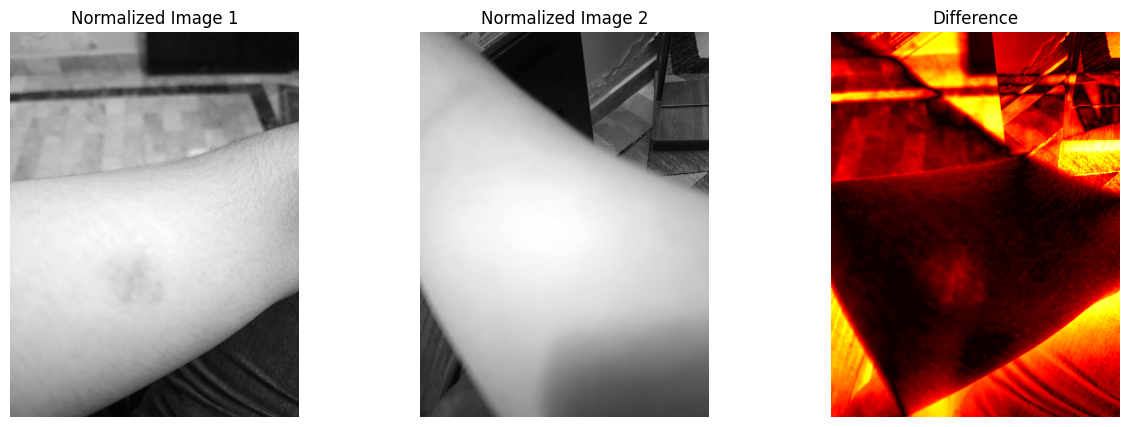

In [8]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the images
image1_path = '1.jpg'
image2_path = '2.jpg'

image1 = Image.open(image1_path).convert('L')  # Convert to grayscale
image2 = Image.open(image2_path).convert('L')

# Convert to numpy arrays
image1_np = np.array(image1).astype(np.float32)
image2_np = np.array(image2).astype(np.float32)

# Normalize images by scaling pixel values between 0 and 1
image1_np /= 255.0
image2_np /= 255.0

# Compare the two images
diff = np.abs(image1_np - image2_np)

# Plot the images and their differences
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image1_np, cmap='gray')
axs[0].set_title("Normalized Image 1")
axs[0].axis('off')

axs[1].imshow(image2_np, cmap='gray')
axs[1].set_title("Normalized Image 2")
axs[1].axis('off')

axs[2].imshow(diff, cmap='hot')
axs[2].set_title("Difference")
axs[2].axis('off')

plt.show()


In [11]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the images
def load_and_preprocess_image(img_path):
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    # Add an extra dimension to represent batch size
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocess the image using ResNet50 preprocessing function
    img_array = preprocess_input(img_array)
    return img_array

# Load the "before" and "after" images
before_img = load_and_preprocess_image('2.jpg')
after_img = load_and_preprocess_image('1.jpg')

# Make predictions using the Siamese model
prediction = siamese_improvement_model.predict([before_img, after_img])

# Interpret the result
if prediction >= 0.5:
    print("Improvement detected!")
else:
    print("No improvement detected.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Improvement detected!
